In [1]:
import pandas as pd
rbp = '441_PUM2_K562'
model = 'shape'
data = pd.read_csv(f'../results/shape/10/out/infer/{rbp}_PrismNet_pu_{rbp}.tsv.probs.highprob', header = None, sep = '\t')
har = pd.read_csv(f'../results/shape/10/out/har/{rbp}_PrismNet_pu_{rbp}_PrismNet_pu_{rbp}.tsv.probs.highprob.har', sep = '\t')
out = f'../results/shape/10/out/infer/{rbp}_PrismNet_pu_{rbp}_PrismNet_pu_{rbp}.tsv.probs.highprob.har.merged'

In [2]:
merged = pd.concat([data,har], axis = 1)

In [51]:
# new HAR detection methods
import numpy as np
import scipy.signal

har = []
non = []

merged['full_attention_score_array'] = merged['full_attention_score'].apply(lambda s: np.array([float(i) for i in s.split(',')]))
for index, row in merged.iterrows():
    peaks, property_ = scipy.signal.find_peaks(-row['full_attention_score_array'], 
                                               height = np.mean(-row['full_attention_score_array']),
                                              distance = 20)
    peak_start = [max(0,i-10) for i in peaks]
    peak_end = [i+10 for i in peaks]
    
    sequence = [row[2][start:end] for start,end in zip(peak_start, peak_end)]
    
    peak_df = pd.DataFrame([peak_start, peak_end, sequence], index = ['start', 'end', 'sequence']).T
    peak_df['index'] = index
    
    # control non-HAR regions
    non_har_starts = []
    non_har_ends = []
    non_har_start = 0
    for start, end in zip(peak_start, peak_end):
        
        non_har_end = start
        
        non_har_starts.append(non_har_start)
        non_har_ends.append(non_har_end)
        
        non_har_start = end
    non_har_starts.append(non_har_start)
    non_har_ends.append(len(row[2]))
    non_har_sequence = [row[2][start:end] for start,end in zip(non_har_starts, non_har_ends)]
    
    nonhar_df = pd.DataFrame([non_har_starts, non_har_ends, non_har_sequence], index = ['start', 'end', 'sequence']).T
    nonhar_df['index'] = index
    
    har.append(peak_df)
    non.append(nonhar_df)

In [52]:
har = pd.concat(har, axis = 0)
har.to_csv(f'../results/shape/10/out/infer/{rbp}_PrismNet_pu_{rbp}_PrismNet_pu_{rbp}.harpeak.tsv', sep = '\t', index = False)
nonhar = pd.concat(non, axis = 0)
nonhar.to_csv(f'../results/shape/10/out/infer/{rbp}_PrismNet_pu_{rbp}_PrismNet_pu_{rbp}.nonharpeak.tsv', sep = '\t', index = False)

In [53]:
har.head()

,start,end,sequence,index
0,0,17,TAAATGTGTTTTTATTT,0
1,68,88,GGTGGTAAAGGTATTCTTAA,0
0,4,24,AACTTAAAATGTTTACACAC,1
1,35,55,CTACTGTTTGTGAATGTCTG,1
2,64,84,GAAACATGTCTATACGATCG,1


In [37]:
peak_end

[33, 94]

In [38]:
non_har_starts

[0, 33]

In [39]:
non_har_ends

[13, 74]

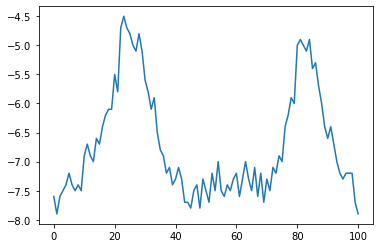

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(-row['full_attention_score_array'])

In [30]:
property_

{'peak_heights': array([-4.5, -4.9])}

In [3]:
merged['har_seq'] = merged.apply(lambda row: row[2][row['start']:row['end']], axis = 1)

In [4]:
merged['other_seq'] = merged.apply(lambda row: row[2][0:row['start']] if row['start']>30 else row[2][row['end']:], axis = 1)

In [5]:
merged['other_seq'].str.len()

0       72
1       74
2       28
3       70
4       74
        ..
1712    89
1713    74
1714    59
1715    60
1716    55
Name: other_seq, Length: 1717, dtype: int64

In [6]:
merged.to_csv(out, sep = '\t')

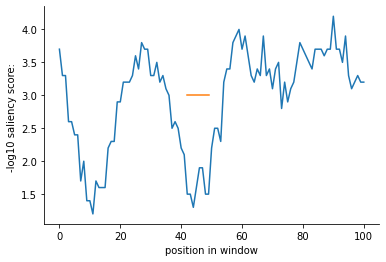

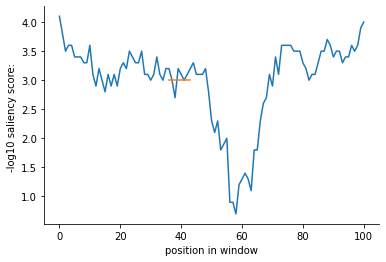

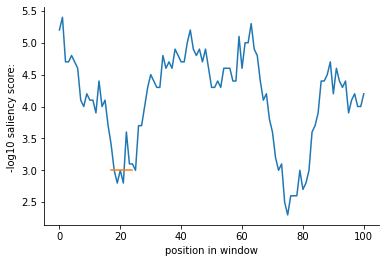

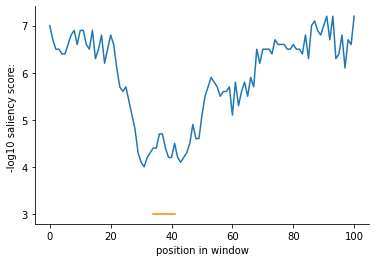

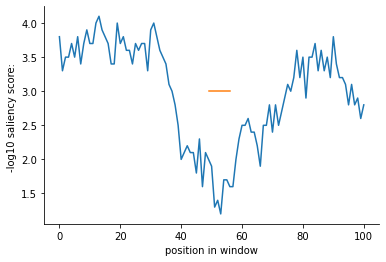

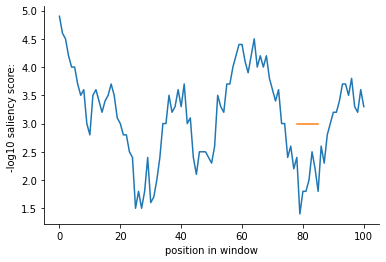

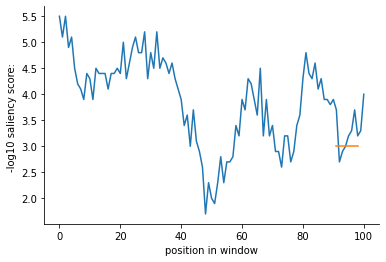

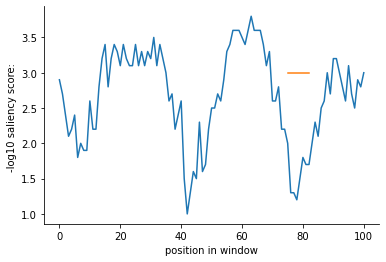

In [47]:

indices = merged.loc[(merged[4]==-1)&merged[2].str.contains('TGTAATA')].index
for id_ in indices:
    f,ax = plt.subplots()
    plt.plot(merged['full_attention_score_array'].iloc[id_])
    plt.ylabel('-log10 saliency score: ')
    plt.xlabel('position in window')
    seq = merged[2].iloc[id_]
    motif_pos = seq.index('TGTAATA')
    plt.plot([motif_pos, motif_pos+7], [3, 3], label = 'TGTAATA')
    sns.despine()

In [28]:
merged['start'].iloc[3]

70

In [46]:
merged.loc[(merged[4]==-1)&merged[2].str.contains('TGTAATA')&merged[2].str.contains('ATA')]

,0,1,2,3,4,5,index,region_prob,start,end,full_attention_score,har_seq,other_seq,full_attention_score_array
267,chr2,ENSG00000180398.13;MCFD2;coding_tp_utr:3,GCAGCAGATTGTAATTTGGTTTATTGGATGTGATGGACGTTCTGTA...,"0.3,0.1,1.0,0.2,0.1,0.0,0.8,0.1,0.1,0.0,0.2,0....",-1.0,46902068,267,0.991491,11,31,"3.7,3.3,3.3,2.6,2.6,2.4,2.4,1.7,2.0,1.4,1.4,1....",TAATTTGGTTTATTGGATGT,GATGGACGTTCTGTAATAGAAAACCTGAAACGATGATTGAATGGGA...,"[3.7, 3.3, 3.3, 2.6, 2.6, 2.4, 2.4, 1.7, 2.0, ..."
453,chr17,ENSG00000108829.10;LRRC59;cds:0,GCTGCCCTTCCAAAGGCCACCATCCTGGATCTGTCTTGTAATAAAC...,"0.3,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.1,0.1,0.0,0....",-1.0,50394928,453,0.990928,58,78,"4.1,3.8,3.5,3.6,3.6,3.4,3.4,3.4,3.3,3.3,3.6,3....",CG,GCTGCCCTTCCAAAGGCCACCATCCTGGATCTGTCTTGTAATAAAC...,"[4.1, 3.8, 3.5, 3.6, 3.6, 3.4, 3.4, 3.4, 3.3, ..."
550,chr16,ENSG00000157106.17;SMG1;coding_tp_utr:22,TTTGGTTGTAAGGCAGATGTAATAGATGACTTCAAAAGCCTGCTCC...,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.4,0.3,-1.0,-1....",-1.0,18806919,550,0.999169,75,95,"5.2,5.4,4.7,4.7,4.8,4.7,4.6,4.1,4.0,4.2,4.1,4....",GTATAGTTTGGCTTCCTCTG,TTTGGTTGTAAGGCAGATGTAATAGATGACTTCAAAAGCCTGCTCC...,"[5.2, 5.4, 4.7, 4.7, 4.8, 4.7, 4.6, 4.1, 4.0, ..."
813,chr2,ENSG00000168288.13;MMADHC;coding_tp_utr:4,CAGAAATATCCATTCATTTGCTGTACTATTTGTATGTAATATTTGG...,"0.1,0.0,0.0,0.2,0.3,0.1,0.1,0.1,0.0,0.0,0.0,0....",-1.0,149569888,813,0.999748,31,51,"7.0,6.7,6.5,6.5,6.4,6.4,6.6,6.8,6.9,6.6,6.9,6....",GTATGTAATATTTGGGTTGA,CAGAAATATCCATTCATTTGCTGTACTATTT,"[7.0, 6.7, 6.5, 6.5, 6.4, 6.4, 6.6, 6.8, 6.9, ..."
931,chr3,ENSG00000120742.11;SERP1;coding_tp_utr:21,ACTCTTTTGAACTGAAAGCACACTCCCTTATAGGTTCATGTAACTG...,"0.9,0.3,0.6,0.1,0.3,0.1,0.2,0.6,0.3,0.1,0.3,0....",-1.0,150543930,931,0.997369,53,73,"3.8,3.3,3.5,3.5,3.7,3.5,3.8,3.4,3.7,3.9,3.7,3....",ATAAGGTGCTTATAAATGGA,ACTCTTTTGAACTGAAAGCACACTCCCTTATAGGTTCATGTAACTG...,"[3.8, 3.3, 3.5, 3.5, 3.7, 3.5, 3.8, 3.4, 3.7, ..."
992,chr7,ENSG00000172115.9;CYCS;coding_tp_utr:46,TATGCCAATCTAATTATAATTCCCTGTATTTAAAATGGTTTCTTTT...,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...",-1.0,25123106,992,0.994288,79,99,"4.9,4.6,4.5,4.2,4.0,4.0,3.7,3.5,3.6,3.0,2.8,3....",GTAATATTAAAGATTATTCA,TATGCCAATCTAATTATAATTCCCTGTATTTAAAATGGTTTCTTTT...,"[4.9, 4.6, 4.5, 4.2, 4.0, 4.0, 3.7, 3.5, 3.6, ..."
1231,chr4,ENSG00000138757.14;G3BP2;coding_tp_utr:19,GGCTGCTCAACACACTCCTCCTCCCCTTTTTTCCTTTCTTTAAGCT...,"0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.4,0.4,0.3,0.4,0....",-1.0,75644546,1231,0.999732,48,68,"5.5,5.1,5.5,4.9,5.1,4.5,4.2,4.1,3.9,4.4,4.3,3....",GTACAGTGAAAATTGTCTTT,GGCTGCTCAACACACTCCTCCTCCCCTTTTTTCCTTTCTTTAAGCTGT,"[5.5, 5.1, 5.5, 4.9, 5.1, 4.5, 4.2, 4.1, 3.9, ..."
1489,chr1,ENSG00000127483.19;HP1BP3;coding_tp_utr:42,CTGGAAGTAAAATGGAGGCACAATATAGCACTGACTGAGTTGTAAA...,"0.5,0.1,0.2,0.8,0.1,0.4,0.9,0.8,0.2,0.5,0.5,0....",-1.0,20744303,1489,0.992592,42,62,"2.9,2.7,2.4,2.1,2.2,2.4,1.8,2.0,1.9,1.9,2.6,2....",TAAAGCCTCCTGCCTGGAGA,CTGGAAGTAAAATGGAGGCACAATATAGCACTGACTGAGTTG,"[2.9, 2.7, 2.4, 2.1, 2.2, 2.4, 1.8, 2.0, 1.9, ..."
